# Second stage CEF Fit to $\rm Cs Er Se_2$

This time we fit EVERYthing, and we also include the results from $\rm KErSe_2$ fits to compare to the fit from CES_CEF_fitPC.ipynb.

Allen Scheie, from Ovi Garlea's data

November 2019

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator
import sys

import PyCrystalField as cef
from pythonlib.MsliceData import mslice
cpal1 = plt.cm.Set1(np.arange(9))


## Import all the data

datadirectory = 'CES_CEF_data/'
cutlist =   ['CES_100K_9meV',            'CES_2K_9meV',
            'CES_50K_9meV',            'CES_2K_9meV_3T',
            'CES_2K_9meV_5T',            'CES_2K_9meV_0T',
            'CES_2K_9meV_1T',            'CES_2K_9meV_2T',
            'CES_2K_9meV_0Tb',    'CES_2K_30meV']

ProtonCharges = [7.97, 8*3, 8*3+5.61, 8+6.59, 5.07, 2, 4,4,1.13, 8*4+5.1]  
# The proton charge doesn't seem to correct the normalization problem.
# Rather, the sample seems to have decreased in intensity post-5T field...
# See the cell below where I derive the scale factor.
scalefactor = 1.66582869
Norm = [scalefactor, 1,1, scalefactor, scalefactor, scalefactor, 
        scalefactor, scalefactor, scalefactor, scalefactor,]

DATA = {}
for i,cn in enumerate(cutlist):
    DATA[cn] = mslice(datadirectory+cn)
    DATA[cn].normalize(1e3*Norm[i])
    
    
## Define data

alldata = [DATA[cn] for cn in ['CES_2K_9meV', 'CES_50K_9meV']]
datatemps = [1.8, 50]

In [2]:
ll, ul = 160, 260
def scalefitfun(x, a):
    return a*DATA['CES_2K_9meV_0T'].ci[ll:ul]
reference = DATA['CES_2K_9meV']
pscaleA, cscaleB = curve_fit(scalefitfun, reference.cx[ll:ul], reference.ci[ll:ul], p0=[2])
def scalefitfun(x, a):
    return a*DATA['CES_2K_9meV_0Tb'].ci[ll:ul]
reference = DATA['CES_2K_9meV']
pscaleB, cscaleB = curve_fit(scalefitfun, reference.cx[ll:ul], reference.ci[ll:ul], p0=[2])
print((pscaleA+pscaleB)/2)

scalevalue = np.mean([pscaleA, pscaleB])

[1.]


In [3]:
## Pick out observed eigenvalues
from scipy.special import wofz

def gaus(x, a, x0, sig):
    return a/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - x0)/sig, 2.)/2.)

def voigt(x, a, x0, alpha, gamma):
    """ Return the Voigt line shape at x with Lorentzian component FWHM gamma
    and Gaussian component FWHM alpha."""
    sigma = (0.5*alpha) / np.sqrt(2 * np.log(2))
    return a*np.real(wofz(((x-x0) + 1j*(0.5*gamma))/sigma/np.sqrt(2))) / sigma\
                                                        /np.sqrt(2*np.pi)

dx, dy, de = alldata[0].cx, alldata[0].ci, alldata[0].ce

def gausfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4):
    return gaus(x-x0, a0,0,w0) + gaus(x-x0, a1,x1,w1) + gaus(x-x0, a2,x2,w2) +\
            gaus(x-x0, a3,x3,w3) + gaus(x-x0, a4,x4,w4) + 0.45

LW = 0.1
def voigtfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4, lw0, lw):
    return voigt(x-x0, a0,0,w0, lw0) + voigt(x-x0, a1,x1,w1, lw) + voigt(x-x0, a2,x2,w2, lw) +\
            voigt(x-x0, a3,x3,w3, lw) + voigt(x-x0, a4,x4,w4, lw) + 0.45

p0 = [56, 0.15,0.27, 8,0.67,0.25, 5,3.27,0.25, 3,5.0,0.10, 2,5.25,0.10, 0.1, 0.1]

poptinitial, pcovinitial = curve_fit(voigtfitfun, dx, dy, sigma=de, p0=p0)
uncinitial = np.sqrt(np.diag(pcovinitial))

f, ax = plt.subplots(1,2, figsize=(8,3.5))

ax[0].errorbar(dx,dy,de, marker='.')
xxx = np.linspace(-2,10,300)
# ax[0].plot(xxx, voigtfitfun(xxx, *p0), zorder=10)
ax[0].plot(xxx, voigtfitfun(xxx, *poptinitial), zorder=10)
ax[0].set_xlim(-2,8)
ax[0].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')

#### 
ObsEnergies, DOE = [poptinitial[3*i+1] for i in range(0,5)],  [uncinitial[3*i+1] for i in range(0,5)], 
ObsWidths, DOW = [poptinitial[3*i+2] for i in range(0,5)],    [uncinitial[3*i+2] for i in range(0,5)]

## Adjust the measured observed width so it matches the peak (not perfectly Gaussian...)
print(ObsEnergies, ObsWidths, poptinitial[-1])
fittedLW = poptinitial[-1]

ax[1].errorbar(ObsEnergies, ObsWidths, xerr = DOE, yerr = DOW, capsize=2, marker='o', 
               ls='none', color='purple', label='Obs. peaks')
def straightline(x,a,b):
    return a*x + b
width_popt, width_pcov = curve_fit(straightline, ObsEnergies, ObsWidths, sigma=DOW, p0=[-0.008,0.16])
width_popt, width_pcov = curve_fit(straightline, ObsEnergies[1:], ObsWidths[1:],  p0=[-0.008,0.16])
xxx = np.linspace(-6,8,3)
ax[1].plot(xxx, straightline(xxx, *width_popt), color='green', ls='--', label='Linear fit')
# ax[1].plot(xxx, resfunc(xxx), color='red', ls='--', label = "Ovi's res. func.")
ax[1].set_xlabel("$\\hbar \\omega$ (meV)")
ax[1].set_ylabel("peak width")
ax[1].legend(fontsize=11)

plt.tight_layout()

print(width_popt)

<IPython.core.display.Javascript object>

[0.07517211974600753, 0.7310563754703909, 3.3430389113350087, 5.0971456786049085, 5.377777212698675] [0.4132660062508849, 0.288638322840261, 0.3005368004446522, 0.2815966433551471, 0.1566254770893106] 0.050394384987051934
[-0.01778629  0.32154258]


In [4]:
## Black out the elastic line, because it includes extra contributions from incoherent scattering, background, etc.
from copy import deepcopy

fitdata = deepcopy(alldata)

# fitdata[0][:,:100] *= np.nan
for i in range(len(fitdata)):
    fitdata[i].cx = np.hstack((fitdata[i].cx[20:120], fitdata[i].cx[150:265]))
    fitdata[i].ci = np.hstack((fitdata[i].ci[20:120], fitdata[i].ci[150:265]))
    fitdata[i].ce = np.hstack((fitdata[i].ce[20:120], fitdata[i].ce[150:265]))
    
fitdata[0].cx = fitdata[0].cx[100:]
fitdata[0].ci = fitdata[0].ci[100:]
fitdata[0].ce = fitdata[0].ce[100:]
    
f, ax = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
for i,data in enumerate(fitdata):
    ax[i].errorbar(data.cx, data.ci, data.ce, marker='.')
    ax[i].text(0.95,0.95, str(datatemps[i])+' K', transform=ax[i].transAxes,
              verticalalignment='top', horizontalalignment='right', fontsize=13)
    ax[i].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')
    
plt.tight_layout()
f.subplots_adjust(wspace=0.02)

<IPython.core.display.Javascript object>

## Define global Chi2

In [5]:
# Build Hamiltonian, ignoring the negative stevens operators (because they shouldn't be allowed by symmetry).
ion = 'Er3+'
ionJ = cef.Jion[ion][2]

Er_O = []
for n in range(2,8,2):
    for m in range(0,n+1,3):
        if   n == 6: i = 8 + m
        elif n == 4: i = 3 + m
        elif n == 2: i = m
        Er_O.append(  cef.StevensOp(ionJ,n,m)  )

Coefficients = np.array([-4.02401422e-02, -3.77639706e-04,  1.42541502e-02,  3.17197840e-06,
        2.22389952e-06,  3.80096353e-05])
Er = cef.CFLevels(Er_O, Coefficients)
Er.diagonalize()
        
######################

def bkg(iii, x):
    if iii == 0:
        return gaus(x, 2, 3.5, 2.5) + 0.2  + gaus(x, 7, 0.1, 0.25)
    else:
        return gaus(x, 6.5, 1.5, 5) + 0.1  + gaus(x, 7, 0.1, 0.25)



def err_global_final(CFLevelsObject, coeff, gammas, xoff, pref, thermexp, bkgscale):
    """Global error to all functions passed to it, used for fitting"""
    # define new Hamiltonian
    newH = np.sum([a*b for a,b in zip(CFLevelsObject.O, coeff)], axis=0)
    CFLevelsObject.diagonalize(newH)

    erro = 0

    # Compute error in neutron spectrum
    for i,data in enumerate(fitdata):
        errspec = (pref* CFLevelsObject.normalizedNeutronSpectrum(Earray=data.cx*(1+datatemps[i]*thermexp)-xoff,
                                                                  Temp=datatemps[i],
                                    ResFunc= lambda de: straightline(de, *width_popt), gamma=gammas[i]) )+\
                bkg(i, data.cx)*bkgscale[i] - data.ci
        erro += np.nansum((errspec/data.ce)**2)


    sys.stdout.write("\r err = "+str(erro)+'    ')
    sys.stdout.flush() # important for printing progress
    return erro

# Compare the different best fit coefficients

In [6]:
initialthermexp = 1e-4
bkgscaleinitial = [1,1]

## These starting parameters are taken from CES_CEF_FitPC.ipynb
FitCoefRes1a= {'coeff': np.array([-3.60740328e-02, -3.82694983e-04, -1.38959810e-02,  3.15219896e-06,
       -4.36048862e-06,  3.36282008e-05]), 'pref': np.array([0.42646004]), 
               'gammas': np.array([0.06171637, 0.06374596]), 'xoff': np.array([0.12768043])} 

## These starting parameters are taken from KES_CEF_FitPC.ipynb
FitCoefRes2a= {'coeff': np.array([ 2.32575380e-02, -4.73413709e-04,  1.26946732e-02,  1.08102667e-06,
        4.47713362e-05,  2.23404722e-05]), 'pref': np.array([0.42646004]), 
               'gammas': np.array([0.06171637, 0.06374596]), 'xoff': np.array([0.12768043])} 

## Fit each set of coefficients to refine the final $\chi^2$

In [7]:
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ##############################################################################################
# FitCoefRes1b = Er.fitdata(chisqfunc = err_global_final,  
#                       fitargs = ['coeff','pref'],
#                      method = 'Powell',
#                     coeff = FitCoefRes1a['coeff'], gammas=FitCoefRes1a['gammas'], bkgscale = bkgscaleinitial,
#                     pref=FitCoefRes1a['pref'], xoff = FitCoefRes1a['xoff'],thermexp=initialthermexp)
# ##############################################################################################

##############################################################################################
FitCoefRes2b = Er.fitdata(chisqfunc = err_global_final, 
                      fitargs = ['coeff','pref'], 
                     method = 'Nelder-Mead',
                    coeff = FitCoefRes2a['coeff'], gammas=FitCoefRes2a['gammas'], bkgscale = bkgscaleinitial,
                    pref=FitCoefRes2a['pref'], xoff = FitCoefRes2a['xoff'], thermexp=initialthermexp)
##############################################################################################

 err = 6126.121404151789     6126.121404151789
 err = 457699.159614773    457699.159614773
Initial err = 457699.159614773 	Final err = 6126.121404151789


In [9]:
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##############################################################################################
FitCoefRes1c = Er.fitdata(chisqfunc = err_global_final,  
                      fitargs = ['coeff','pref','gammas','xoff','thermexp'],
                     method = 'Nelder-Mead',
                    coeff = FitCoefRes1a['coeff'], gammas=FitCoefRes1a['gammas'], bkgscale = bkgscaleinitial,
                    pref=FitCoefRes1a['pref'], xoff = FitCoefRes1a['xoff'],thermexp=initialthermexp)
##############################################################################################

##############################################################################################
FitCoefRes2c = Er.fitdata(chisqfunc = err_global_final, 
                      fitargs = ['coeff','pref','gammas','xoff','thermexp'], 
                     method = 'Powell',
                    coeff = FitCoefRes2b['coeff'], gammas=FitCoefRes2a['gammas'], bkgscale = bkgscaleinitial,
                    pref=FitCoefRes2b['pref'], xoff = FitCoefRes2a['xoff'], thermexp=initialthermexp)
##############################################################################################

# reduce the chi2
FCR = [FitCoefRes1c, FitCoefRes2c]
for fcr in FCR:
    freeparams = len(np.hstack([fcr[key] for key in fcr]))
    fcr['Chisq'] /= len(np.hstack(([alldata[i].cx for i in range(len(alldata))]))) - freeparams

 err = 5110.36454451194      5110.36454451194
 err = 5422.023487213863    5422.023487213863
Initial err = 5422.023487213863 	Final err = 5110.36454451194
 err = 6110.20214313568          6110.20214313568
 err = 6126.121404151789    6126.121404151789
Initial err = 6126.121404151789 	Final err = 6110.20214313568


In [10]:
print(FitCoefRes1c, '\n')
print(FitCoefRes2c, '\n')

ErCoefFit1 = cef.CFLevels(Er_O, FitCoefRes1c['coeff'])
ErCoefFit1.diagonalize()
ErCoefFit2 = cef.CFLevels(Er_O, FitCoefRes2c['coeff'])
ErCoefFit2.diagonalize()

print(ErCoefFit1.eigenvectors[0], '\n')
print(ErCoefFit2.eigenvectors[0], '\n')

{'coeff': array([-3.55882648e-02, -3.84909550e-04, -1.39341508e-02,  3.15375656e-06,
       -4.69499691e-06,  3.38115268e-05]), 'pref': array([0.43061789]), 'gammas': array([0.06108859, 0.07277677]), 'xoff': array([0.1275053]), 'thermexp': array([0.00013195]), 'Chisq': 8.691096164135953} 

{'coeff': array([ 3.11434439e-02, -4.72004277e-04,  1.25927269e-02,  9.36535996e-07,
        4.71842317e-05,  2.00827121e-05]), 'pref': array([0.41205986]), 'gammas': array([0.0612107 , 0.06835898]), 'xoff': array([0.12727767]), 'thermexp': array([0.00010667]), 'Chisq': 10.391500243428027} 

[ 0.          0.57385414 -0.02423379  0.         -0.50249657  0.06645808
  0.          0.5052531  -0.10142795  0.          0.33105421 -0.10087459
  0.          0.12071817 -0.11519939  0.        ] 

[ 0.63360562  0.          0.          0.52393225  0.          0.
  0.51684586  0.          0.         -0.23815658  0.          0.
  0.01380984  0.          0.          0.        ] 



In [11]:
# Save the data to be used in PlotFinalResults.ipynb

np.save('CES_bestfitcoeff',[FitCoefRes1c, FitCoefRes2c])

<IPython.core.display.Javascript object>


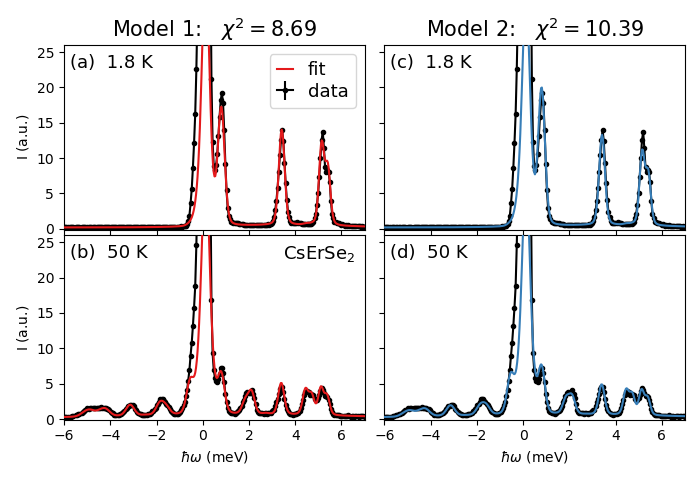

In [12]:
xxx = np.linspace(-10,30,1200)

fig2, ax = plt.subplots(2,2, figsize=(7,4.8), sharex=True, sharey=True)
for i,data in enumerate(alldata):
    for j in range(2):
        ax[i,j].errorbar(data.cx, data.ci, data.ce, marker='.', label='data', color='k')
    ax[-1,i].set_xlim(-6,7)
    ax[i,0].set_ylabel('$\\rm I$ (a.u.)')

    ax[i,0].plot(xxx, (FitCoefRes1c['pref']*ErCoefFit1.normalizedNeutronSpectrum(
                 Earray=xxx*(1+datatemps[i]*FitCoefRes1c['thermexp'])-FitCoefRes1c['xoff'], Temp=datatemps[i],
                                    ResFunc=lambda de: straightline(de,*width_popt),  
                                    gamma=FitCoefRes1c['gammas'][i])  + bkg(i, xxx)) ,
              zorder=10, label='fit', color=cpal1[0])
    
    ax[i,1].plot(xxx, (FitCoefRes2c['pref']*ErCoefFit2.normalizedNeutronSpectrum(
                 Earray=xxx*(1+datatemps[i]*FitCoefRes2c['thermexp'])-FitCoefRes2c['xoff'], Temp=datatemps[i],
                                    ResFunc=lambda de: straightline(de,*width_popt),  
                                    gamma=FitCoefRes2c['gammas'][i]) + bkg(i, xxx)),
               zorder=10, color=cpal1[1])
               

    ax[i,0].set_ylim(-0.1,26)
    


    
ax[0,0].legend(loc=1, fontsize=13, handlelength=0.9, labelspacing=0.2)


    
subplotlabels = 'abcdefghijk'
for i, axx in enumerate(ax.T.flatten()):
    axx.text(0.02,0.95, '('+subplotlabels[i]+')  '+str(datatemps[i%2])+' K', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left', fontsize=13)
for i in range(2):
    ax[0,i].set_title('Model '+str(i+1)+':   $\chi^2='+str(np.around(FCR[i]['Chisq'],2))+'$',
                     fontsize=15)
    ax[-1,i].set_xlabel('$\\hbar \\omega$ (meV)')
    
ax[-1,0].text(0.97,0.95, '$\\rm CsErSe_2$', transform=ax[-1,0].transAxes,
              verticalalignment='top', horizontalalignment='right', fontsize=13)
    
plt.tight_layout()
fig2.subplots_adjust(hspace=0.03)

In [13]:
# Compute Magnetization
ion = 'Er3+'

temp = 2
fieldstrengths = np.hstack((np.arange(0,0.7,0.05), np.arange(0.7,5.1,0.1)))
magnetization1 = np.zeros((len(fieldstrengths), 3, 3))
magnetization2 = np.zeros((len(fieldstrengths), 3, 3))

for i, fs in enumerate(fieldstrengths):
    magnetization1[i,0] = ErCoefFit1.magnetization(ion, temp, [fs,0,0])
    magnetization1[i,1] = ErCoefFit1.magnetization(ion, temp, [0,fs,0])
    magnetization1[i,2] = ErCoefFit1.magnetization(ion, temp, [0,0,fs])
    
    magnetization2[i,0] = ErCoefFit2.magnetization(ion, temp, [fs,0,0])
    magnetization2[i,1] = ErCoefFit2.magnetization(ion, temp, [0,fs,0])
    magnetization2[i,2] = ErCoefFit2.magnetization(ion, temp, [0,0,fs])
    
    
### Import magnetization

MHdata = np.genfromtxt('CsErSe2_bulkdata/CsErSe2_MHall.dat', 
                       delimiter='\t', unpack=True, skip_header=1)

<IPython.core.display.Javascript object>


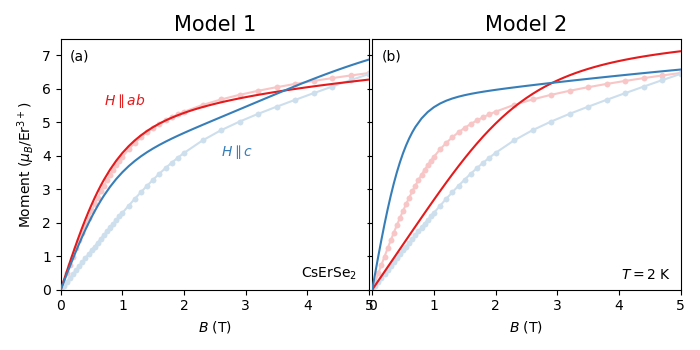

In [14]:
f, ax = plt.subplots(1,2, figsize=(7,3.5), sharex=True, sharey=True)

c_color = cpal1[1]
ab_color = cpal1[0]
abc_colors = [ab_color,ab_color,c_color]

for i in [0,2]:
    ax[0].plot(fieldstrengths, -magnetization1[:,i,i], color=abc_colors[i], zorder=10)
    ax[1].plot(fieldstrengths, -magnetization2[:,i,i], color=abc_colors[i], zorder=10)

ax[0].set_ylabel('Moment ($\mu_B$/Er$^{3+}$)')
ax[0].set_xlim(0,5)
ax[0].set_ylim(0,)

ax[0].text(0.7,5.5,'$H \\parallel ab$', color=cpal1[0])
ax[0].text(2.6,4,'$H \\parallel c$', color=cpal1[1])

ax[-1].text(0.97,0.03,'$T=2$ K', transform=ax[-1].transAxes, 
            verticalalignment='bottom',horizontalalignment='right')

for i,axx in enumerate(ax):
    axx.plot(MHdata[0]/1e4,MHdata[1],  marker='.', color= 0.25*abc_colors[0] + 0.75*np.array([1,1,1,1]))
    axx.plot(MHdata[6]/1e4,MHdata[7],marker='.', color= 0.25*abc_colors[2] + 0.75*np.array([1,1,1,1]))
    axx.set_title('Model '+str(i+1),  fontsize=15)
    axx.set_xlabel('$B$ (T)')
    axx.text(0.03,0.96, '('+subplotlabels[i]+')', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left')
    
ax[0].text(0.96,0.03, '$\\rm CsErSe_2$', transform=ax[0].transAxes,
              verticalalignment='bottom', horizontalalignment='right')
    
plt.tight_layout()
f.subplots_adjust(wspace=0.01)

# Conclusions:
- CEF fits are underdetermined: two models fit the data almost equivalently, but give wildly different anisotropies at low temperature.
- Bulk magnetization matches model 1 much better than Model 2